In [1]:
import pandas as pd
import numpy as np

# PLOTTING

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
sns.set(font_scale=3)
sns.set_style("whitegrid")
sns.set_context("paper")

color = sns.color_palette("colorblind")

In [4]:
#1: Bipolar cells, 3: V1 L2/3, 5: V1 L4 and 4: V1 L5
datasets = [1,3,5,4] 

# Statistic ids
# 5:  DM xz
# 7:  DM z
# 10: DM YZ
# 80: Morphometric statistics
# 63: Sholl intersection profile YZ
# 71: 2D Persistence diagram using radial distance
# 78: 2D Persistence diagram using z-projection
super_set = [5, 7, 10, 80,63,71,78]

#Combined ids
# 100: DM XZ + Morphometric statistics
# 107: 2D Persistence (z-projection) + Morphometric statistics
# 108: DM XZ + 2D Persistence (z-projection) 
# 109: DM XZ + 2D Persistence (z-projection) + Morphometric statistics
combined_ids=[100,107,108,109]

In [5]:
df = pd.read_csv("./data/classification/multiclass_classification_performances.csv").reset_index()
data = df[np.sum(np.sum([[df['statistic_id'] == s] for s in super_set + combined_ids], axis=1),axis=0).astype(bool)]
data = data[data['classifier_id'] == 1]

statistics = pd.read_csv("./data/statistic_descriptions.csv").reset_index()

## Multiclass performance

In [6]:
def get_statistic_labels(ids, labels):
    
    names = [labels[labels["statistic_id"] == sid]['statistic_name'].values[0] for sid in ids]
    
    new_names = [s.replace("_", " ")
                 .replace("smoothed", "")
                 .replace("+", "\n + \n")
                 .replace("vs", "\n vs \n")
                 .replace("distance", "")
                 .replace("dist", "distance")
                 .replace("morphometry", "Morphometric \n statistics")
                 .replace("sholl intersection", "Sholl profile")
                 .replace(" \wo avg thickness", "") 
                 .replace("image", "2D")
                 .replace("vector", "1D")
                 .replace("to", "\n to") 
                 .replace("avg 4starMotif", "Avg 4-star motif")
                 .replace("4starMotif", "4-star motif")
                 .replace(" ed", "")
                 .replace("density map", "")
                 .capitalize()
                 .replace("xz" ,"XZ")
                 .replace("xy", "XY")
                 .replace("yz", "YZ")
                 .replace(" z", " Z")
                 .replace("2d", "2D")
                 .replace("image", "2D")
                 .replace("vector", "1D")
                 .replace("radial", "\n (radial)")
                 .replace("Z-projection", "\n (z-proj)")
                 .replace("1d", "1D")
                 .replace("top 10", "")
                 .replace("all", "")
                 .replace("wo min path angle", "")
                  for s in names]
    
    return new_names

In [7]:
multiclass = data.groupby(['ds_id', 'part_id', 'classifier_id', 'statistic_id' ]).mean().reset_index()

/gpfs01/berens/user/slaturnus/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0.98, 'Multi-class classification')

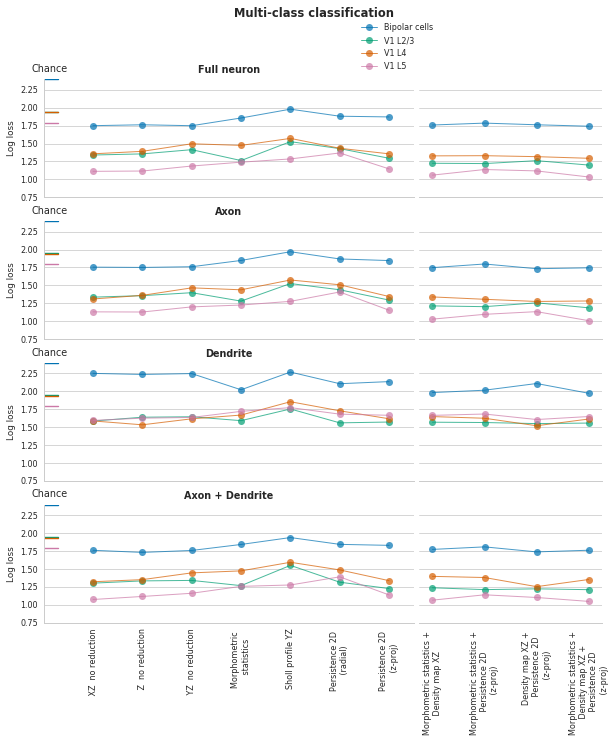

In [8]:
plt.figure(figsize=(10,10))

n = len(super_set)

score = 'log_loss_test'
xticks = list(range(n))
xticks_combined = list(range(0,len(combined_ids)*2,2))
no_plots_row = 9
grid = plt.GridSpec(4,no_plots_row,wspace=0.1, hspace=0.2)
for t,p in [('Full neuron',1),('Axon',2),('Dendrite',3),("Axon + Dendrite", 4)]:
    subplot_index = (p-1)*no_plots_row
    # comined the first 6 subplots to one
    ax = plt.subplot(grid[subplot_index: subplot_index+(no_plots_row-3)])
    
    for k, ds_id in enumerate(datasets):

        data = multiclass[(multiclass['ds_id'] == ds_id) 
                          & (multiclass['part_id'] == p)].set_index("statistic_id")
        y = data.loc[super_set][score]
        ax.plot(xticks,y, c=color[k], marker='o', linewidth=1, alpha=.7, markersize=7,
                     label='ds %s'%str(k+1))

    
    # plot chance levels for data sets
    ax.plot([-1,-.7], [-np.log(1/11)]*2, c=color[0])
    ax.plot([-1,-.7], [-np.log(1/7)]*2, c=color[1])
    ax.plot([-1,-.7], [-np.log(1/7)-0.01]*2, c=color[2])
    ax.plot([-1,-.7], [-np.log(1/6)]*2, c=color[3])
    ax.text(-1.25, 2.5 , 'Chance')
    
    # replace labels
    handles, labels = plt.gca().get_legend_handles_labels()

    if p == 1:
        plt.legend(handles[:4],['Bipolar cells', 'V1 L2/3', 'V1 L4', 'V1 L5'] ,bbox_to_anchor=(.85, 1.5), loc=2, borderaxespad=0.)
    
        
    
    plt.gca().set_xticks(xticks)
    if p < 4:
        ax.set_xticklabels("")
    else:
        x_labels =get_statistic_labels(super_set, statistics)
        lables = ax.set_xticklabels(x_labels, rotation=90)

    plt.ylabel(score[:-5].replace("_", " ").capitalize())
    sns.despine()
    plt.gca().grid(False, axis='x')
    plt.title(t, weight = 'bold')
    plt.ylim([.75,2.4])
    plt.xlim([-1,len(xticks)-.5])
    # plot combined performance
    # combine the last three subplots in a row to one subplot for combined performance
    ax_combined = plt.subplot(grid[subplot_index+no_plots_row-3:subplot_index+no_plots_row])
    
    for k, ds_id in enumerate(datasets):
        # plot the data for each data set
        data = multiclass[(multiclass['ds_id'] == ds_id) & (multiclass['part_id'] == p)].set_index("statistic_id")
        y = data.loc[combined_ids][score]
        ax_combined.plot(xticks_combined,y, c=color[k], marker='o',alpha=.7, linewidth=1, markersize=7)
        
    ax_combined.set_xticks(xticks_combined)
    if p < 4:
        ax_combined.set_xticklabels("")
    else:
        x_labels = ['Morphometric statistics + \n Density map XZ  ', 
             'Morphometric statistics + \n Persistence 2D \n (z-proj)',
             'Density map XZ + \n Persistence 2D \n (z-proj)',
             'Morphometric statistics + \n Density map XZ + \n Persistence 2D \n (z-proj)']
        lables = ax_combined.set_xticklabels(x_labels, rotation=90)
        
    ax_combined.set_yticklabels("")
    ax_combined.spines['left'].set_visible(False)
    sns.despine()
    plt.gca().grid(False, axis='x')
    plt.ylim([.75,2.4])
    plt.xlim([-.5,6.5])
    #plt.ylim([.15,1])
# remove the y axis between the plots
for i_ in range(no_plots_row-3,no_plots_row*4,no_plots_row):
    plt.subplot(grid[i_:i_+3])
    plt.gca().spines['left'].set_visible(False)

plt.suptitle("Multi-class classification", weight = 'bold')




In [9]:
multiclass_all = df[(df['classifier_id'] == 1) 
                    & (df['statistic_id'] != 25)
                   & (df['statistic_id'] != 72)
                   & (df['statistic_id'] != 73)].groupby(['ds_id','part_id', 'classifier_id', 'statistic_id']).mean().reset_index()

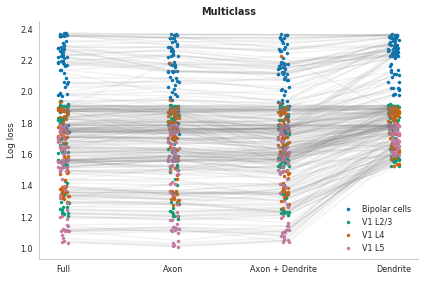

In [10]:
plt.figure()
n = len(np.unique(multiclass_all['statistic_id']))
rand = np.random.random(n)*0.1 +0.2
index = ['ds_id', 'statistic_id']

# plot the lines connecting them
for p1,p2 in [[(1,1),(2,2)],[(2,2),(4,3)], [(4,3),(3,4)]]:
    for l,ds in enumerate([1,3,5,4]):
        d_1 = multiclass_all[(multiclass_all['ds_id'] == ds) & (multiclass_all['part_id'] == p1[0])]
        d_2 = multiclass_all[(multiclass_all['ds_id'] == ds) & (multiclass_all['part_id'] == p2[0])]
        
        join = d_1.set_index(index).join(d_2.set_index(index), rsuffix='_r')
        X = np.array([[p1[1]],[p2[1]]]).repeat(n,axis=1) + rand
        Y = np.vstack((join['log_loss_test'].values,join['log_loss_test_r'].values) )
        plt.plot(X,Y, 'grey', alpha=.1)
        
# plot the individual points
for p,x in [(1,1),(2,2),(4,3), (3,4)]:
    for l,ds in enumerate([1,3,5,4]):
        d = multiclass_all[(multiclass_all['ds_id'] == ds) & (multiclass_all['part_id'] == p)]
        plt.scatter(np.array([x]*n) + rand, d['log_loss_test'], color=color[l],s=10)

plt.grid(False)
plt.ylabel('Log loss')
plt.gca().set_xticks([1.25,2.25,3.25,4.25])
plt.gca().set_xticklabels(['Full', 'Axon', 'Axon + Dendrite' ,'Dendrite'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4],['Bipolar cells', 'V1 L2/3', 'V1 L4', 'V1 L5'] )
sns.despine()
plt.title('Multiclass', weight='bold')
plt.tight_layout()


## Conversion from log loss to accuracy

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

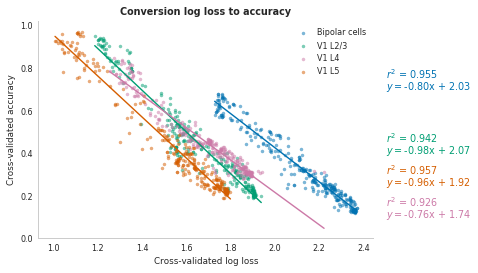

In [12]:
d = multiclass_all
colors = sns.color_palette('colorblind')
lines = []
labels={1:'Bipolar cells', 3:'V1 L2/3', 4:'V1 L5', 5: 'V1 L4'}
for k,ds in [(0,1),(1,3),(3,5),(2,4)]:
    lr = LinearRegression()
    D = d[d['ds_id']== ds]
    X = D['log_loss_test'].values
    p = np.percentile(X,99.5)

    Y = D['accuracy_test'].values

    
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)

    x = np.linspace(np.min(X),np.max(X),50)
        
    lr.fit(X,Y) 
    plt.scatter(d[d['ds_id'] ==ds]['log_loss_test'], 
                d[d['ds_id'] ==ds]['accuracy_test'],alpha=.5, s=10, color=colors[k], label=labels[ds] )

    plt.plot(x,(lr.coef_*x + lr.intercept_).T,c=colors[k])
    plt.text(2.5,.9 - .15*ds,'$r^2$ = %.3f'%r2_score(Y,lr.predict(X)), color=colors[k])
    plt.text(2.5,.85 - .15*ds,'$y=$%.2fx + %.2f'%(lr.coef_[0],lr.intercept_),color=colors[k])
    
plt.title('Conversion log loss to accuracy', weight='bold')
plt.xlabel('Cross-validated log loss')
plt.ylabel('Cross-validated accuracy')
plt.legend(bbox_to_anchor = (1.,1), frameon=False)
sns.despine()
plt.gca().grid(False)